In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
df = pd.read_csv('df_financial.csv', index_col=0)
df.head()

,Company,Ticker,scores_2016,scores_2017,scores_2018,scores_2019,scores_2020,total_2016,total_2017,total_2018,...,adjusted_01.01.2020,adjusted_01.01.2021,adjusted_01.01.2022,Exchange_ticker,Exchange_01.01.2017,Exchange_01.01.2018,Exchange_01.01.2019,Exchange_01.01.2020,Exchange_01.01.2021,Exchange_01.01.2022
0,ABNAMRO,ABN.AS,7816,1041,704,964,991,24309,3212,2377,...,15.720905,9.011941,14.872027,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
1,Amazon,AMZN,1226,1503,1440,341,512,3597,4072,3856,...,1847.839966,3256.929932,3334.340088,^IXIC,5429.080078,7006.899902,6635.279785,8972.599609,12888.280273,15644.969727
2,asr,ASRNL.AS,4738,4297,4956,5293,5948,18578,15610,18691,...,33.235754,38.556988,46.183463,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
3,bam,BAMNB.AS,4242,4712,4816,5863,4492,10768,12691,12570,...,3.053746,2.028253,3.096263,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817
4,CocaCola,KO,3513,3526,3738,5464,3886,11402,11692,11956,...,51.882885,53.163948,59.209999,^NYA,11154.349609,12902.719727,11374.389648,13913.030273,14524.799805,17164.130859


In [82]:
df['constant'] = [1 for i in range(df.shape[0])]
df.head()

,Company,Ticker,scores_2016,scores_2017,scores_2018,scores_2019,scores_2020,total_2016,total_2017,total_2018,...,adjusted_01.01.2021,adjusted_01.01.2022,Exchange_ticker,Exchange_01.01.2017,Exchange_01.01.2018,Exchange_01.01.2019,Exchange_01.01.2020,Exchange_01.01.2021,Exchange_01.01.2022,constant
0,ABNAMRO,ABN.AS,7816,1041,704,964,991,24309,3212,2377,...,9.011941,14.872027,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817,1
1,Amazon,AMZN,1226,1503,1440,341,512,3597,4072,3856,...,3256.929932,3334.340088,^IXIC,5429.080078,7006.899902,6635.279785,8972.599609,12888.280273,15644.969727,1
2,asr,ASRNL.AS,4738,4297,4956,5293,5948,18578,15610,18691,...,38.556988,46.183463,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817,1
3,bam,BAMNB.AS,4242,4712,4816,5863,4492,10768,12691,12570,...,2.028253,3.096263,^AEX,512.000729,654.017452,556.633446,686.555184,776.160404,909.750817,1
4,CocaCola,KO,3513,3526,3738,5464,3886,11402,11692,11956,...,53.163948,59.209999,^NYA,11154.349609,12902.719727,11374.389648,13913.030273,14524.799805,17164.130859,1


In [83]:
for i in range(5):
    df['return_%d'%(2017+i)] = df['adjusted_01.01.%d'%(2018+i)]/df['adjusted_01.01.%d'%(2017+i)]-1
    df['exchange_return_%d'%(2017+i)] = df['Exchange_01.01.%d'%(2018+i)]/df['Exchange_01.01.%d'%(2017+i)]-1

In [84]:
mean_score = np.asarray([df['scores_%d'%(2016+i)].values for i in range(5)]).ravel().mean()
std_score = np.asarray([df['scores_%d'%(2016+i)].values for i in range(5)]).ravel().std()

for i in range(5):
    df['scores_%d'%(2016+i)] = (df['scores_%d'%(2016+i)] - mean_score)/(std_score)

In [85]:
columns = ['Company', 'scores_2016', 'scores_2017', 'scores_2018',
       'scores_2019', 'scores_2020', 'total_2016', 'total_2017', 'total_2018',
       'total_2019', 'total_2020', 'sector', 'country',
       'Total_revenue_2016', 'Total_revenue_2017', 'Total_revenue_2018',
       'Total_revenue_2019', 'Total_revenue_2020', 'Total_revenue_2021', 
       'Revenue_growth_2017', 'Revenue_growth_2018',
       'Revenue_growth_2019', 'Revenue_growth_2020', 'Revenue_growth_2021',
       'Avg_market_cap_2017', 'Avg_market_cap_2018', 'Avg_market_cap_2019',
       'Avg_market_cap_2020', 'Avg_market_cap_2021', 'return_2017','return_2018',
       'return_2019','return_2020', 'return_2021','exchange_return_2017', 'exchange_return_2018',
       'exchange_return_2019', 'exchange_return_2020','exchange_return_2021', 'constant']
#filtering out unwanted columns
df = df[columns]

In [86]:
df_fin = pd.get_dummies(df, columns=['sector', 'country'])

In [87]:
columns = ['Company', 'constant',
       'sector_Communication Services', 'sector_Consumer Cyclical',
       'sector_Consumer Defensive', 'sector_Energy',
       'sector_Financial Services', 'sector_Healthcare', 'sector_Industrials',
       'sector_Technology', 'country_Denmark', 'country_Germany',
       'country_Netherlands', 'country_Sweden', 'country_Switzerland',
       'country_United Kingdom', 'country_United States']
       
df_pivot = df_fin[columns]

newdf = pd.DataFrame(np.repeat(df_pivot.values, 5, axis=0))

year = np.asarray([[2017, 2018, 2019, 2020, 2021] for i in range(df.shape[0])]).ravel()
newdf['year'] = year
newdf.columns = columns+['year']
newdf.head()

,Company,constant,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Technology,country_Denmark,country_Germany,country_Netherlands,country_Sweden,country_Switzerland,country_United Kingdom,country_United States,year
0,ABNAMRO,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2017
1,ABNAMRO,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2018
2,ABNAMRO,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2019
3,ABNAMRO,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2020
4,ABNAMRO,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2021


In [88]:
df.columns

Index(['Company', 'scores_2016', 'scores_2017', 'scores_2018', 'scores_2019',
       'scores_2020', 'total_2016', 'total_2017', 'total_2018', 'total_2019',
       'total_2020', 'sector', 'country', 'Total_revenue_2016',
       'Total_revenue_2017', 'Total_revenue_2018', 'Total_revenue_2019',
       'Total_revenue_2020', 'Total_revenue_2021', 'Revenue_growth_2017',
       'Revenue_growth_2018', 'Revenue_growth_2019', 'Revenue_growth_2020',
       'Revenue_growth_2021', 'Avg_market_cap_2017', 'Avg_market_cap_2018',
       'Avg_market_cap_2019', 'Avg_market_cap_2020', 'Avg_market_cap_2021',
       'return_2017', 'return_2018', 'return_2019', 'return_2020',
       'return_2021', 'exchange_return_2017', 'exchange_return_2018',
       'exchange_return_2019', 'exchange_return_2020', 'exchange_return_2021',
       'constant'],
      dtype='object')

In [90]:
scores = []
totals = []
revenues = []
market_caps = []
growths = []
returns = []
exchanges = []

for company in df_pivot['Company'].values:
       for i in range(5):
              score = df_fin[df_fin['Company']==company]['scores_%d'%(2016+i)].values[0]
              scores.append(score)
              total = df_fin[df_fin['Company']==company]['total_%d'%(2016+i)].values[0]
              totals.append(total)
              revenue = df_fin[df_fin['Company']==company]['Total_revenue_%d'%(2017+i)].values[0]
              revenues.append(revenue)
              market_cap = df_fin[df_fin['Company']==company]['Avg_market_cap_%d'%(2017+i)].values[0]
              market_caps.append(market_cap)
              growth = df_fin[df_fin['Company']==company]['Revenue_growth_%d'%(2017+i)].values[0]
              growths.append(growth)
              return_ = df_fin[df_fin['Company']==company]['return_%d'%(2017+i)].values[0]
              returns.append(return_)
              exchange = df_fin[df_fin['Company']==company]['exchange_return_%d'%(2017+i)].values[0]
              exchanges.append(exchange)
newdf['score'] = scores
newdf['total'] = totals
newdf['revenue'] = revenues
newdf['market_cap'] = market_caps
newdf['growth'] = growths
newdf['return'] = returns
newdf['exchange_return'] = exchanges

In [94]:
newdf.head(5)

,Company,constant,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Technology,...,country_United Kingdom,country_United States,year,score,total,revenue,market_cap,growth,return,exchange_return
0,ABNAMRO,1,0,0,0,0,1,0,0,0,...,0,0,2017,2.181706,24309,1.115260e+07,25592.721645,0.233616,0.505744,0.277376
1,ABNAMRO,1,0,0,0,0,1,0,0,0,...,0,0,2018,-0.717806,3212,1.026850e+07,26221.405402,-0.079273,-0.224257,-0.148901
2,ABNAMRO,1,0,0,0,0,1,0,0,0,...,0,0,2019,-0.862032,2377,9.431214e+06,19583.062743,-0.081539,-0.149054,0.233406
3,ABNAMRO,1,0,0,0,0,1,0,0,0,...,0,0,2020,-0.750759,3278,9.245832e+06,13175.342147,-0.019656,-0.426754,0.130514
4,ABNAMRO,1,0,0,0,0,1,0,0,0,...,0,0,2021,-0.739204,3902,8.315968e+06,11510.689195,-0.100571,0.650258,0.172117


<AxesSubplot:>

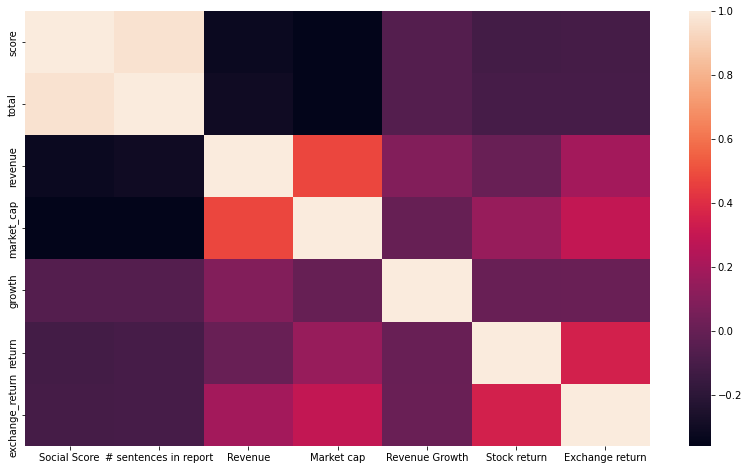

In [92]:
df_fin = newdf
corr_features = ['score', 'total', 'revenue', 'market_cap',
                 'growth', 'return', 'exchange_return'
                 ]
df_corr = df_fin[corr_features]
corr = df_corr.corr()
corr['score']
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(corr, ax=ax, xticklabels=['Social Score', '# sentences in report', 'Revenue', 'Market cap', 'Revenue Growth', 'Stock return', 'Exchange return'])

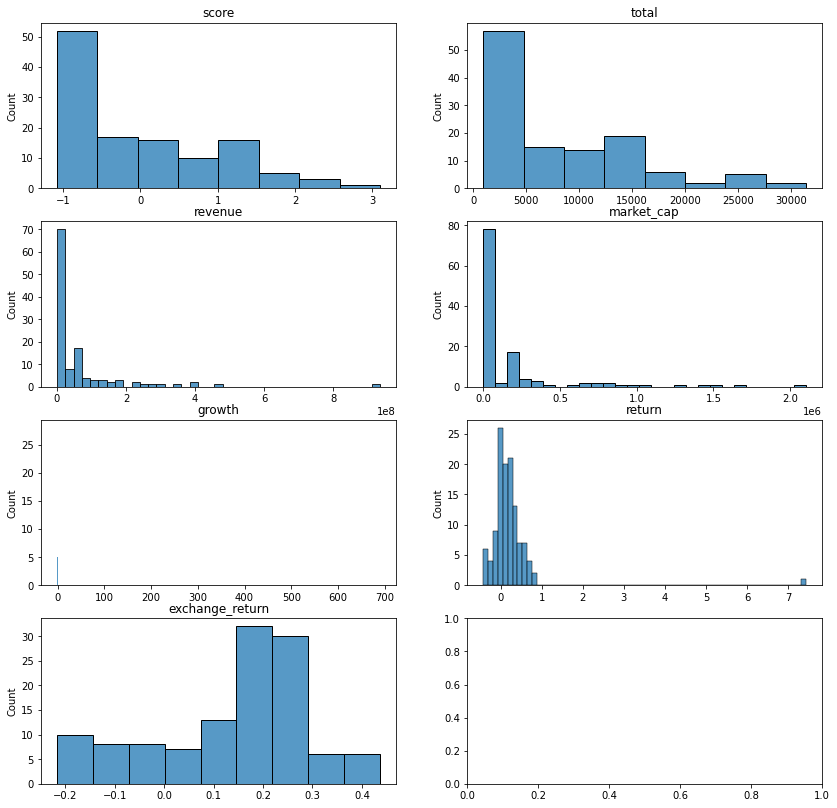

In [104]:
fix, ax = plt.subplots(4,2, figsize=(14,14))

for i, element in enumerate(corr_features):
    sns.histplot(df_fin[element].values, ax = ax[i//2, i%2])
    ax[i//2, i%2].set_title(element)
    

In [105]:
df_fin.columns

Index(['Company', 'constant', 'sector_Communication Services',
       'sector_Consumer Cyclical', 'sector_Consumer Defensive',
       'sector_Energy', 'sector_Financial Services', 'sector_Healthcare',
       'sector_Industrials', 'sector_Technology', 'country_Denmark',
       'country_Germany', 'country_Netherlands', 'country_Sweden',
       'country_Switzerland', 'country_United Kingdom',
       'country_United States', 'year', 'score', 'total', 'revenue',
       'market_cap', 'growth', 'return', 'exchange_return'],
      dtype='object')

First, we try performing pooled OLS

In [128]:
df.groupby('country').count()

,Company,scores_2016,scores_2017,scores_2018,scores_2019,scores_2020,total_2016,total_2017,total_2018,total_2019,...,return_2018,return_2019,return_2020,return_2021,exchange_return_2017,exchange_return_2018,exchange_return_2019,exchange_return_2020,exchange_return_2021,constant
country,,,,,,,,,,,,,,,,,,,,,
Denmark,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Germany,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Netherlands,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Sweden,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Switzerland,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
United Kingdom,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
United States,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [129]:
df.groupby('sector').count()

,Company,scores_2016,scores_2017,scores_2018,scores_2019,scores_2020,total_2016,total_2017,total_2018,total_2019,...,return_2018,return_2019,return_2020,return_2021,exchange_return_2017,exchange_return_2018,exchange_return_2019,exchange_return_2020,exchange_return_2021,constant
sector,,,,,,,,,,,,,,,,,,,,,
Communication Services,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Consumer Cyclical,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Consumer Defensive,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Energy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Financial Services,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Healthcare,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Industrials,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Technology,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [130]:
from linearmodels import PooledOLS
from datetime import datetime

import statsmodels.api as sm

df_fin['year'] = pd.to_datetime(df_fin['year'], format='%Y')
df_fin2 = df_fin.set_index(['Company', 'year'], append=False)



exog = df_fin2[['constant', 'sector_Communication Services',
       'sector_Consumer Cyclical', 'sector_Consumer Defensive',
       'sector_Energy', 'sector_Financial Services', 'sector_Healthcare',
       'sector_Industrials', 'country_Denmark',
       'country_Germany', 'country_Netherlands', 'country_Sweden',
       'country_Switzerland',
       'country_United States', 'score', 'total', 'revenue',
       'market_cap', 'growth', 'exchange_return']]

endog = df_fin2['return']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

(thanks to: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8)

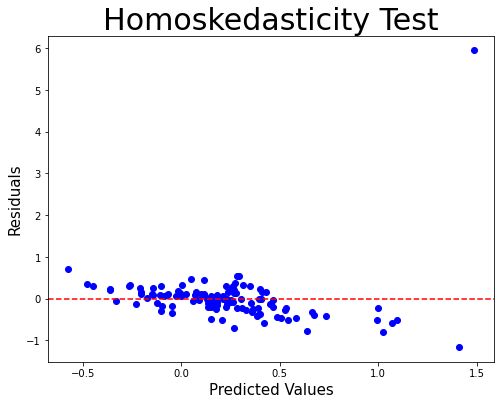

In [134]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [153]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

exog = df_fin2[['constant', 'score', 'total', 'revenue',
       'market_cap', 'growth', 'exchange_return']]

# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True) 
fe_res = model_fe.fit() 
#print results
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 return   R-squared:                        0.1390
Estimator:              RandomEffects   R-squared (Between):              0.2119
No. Observations:                 120   R-squared (Within):               0.1211
Date:                Fri, May 27 2022   R-squared (Overall):              0.1414
Time:                        14:55:34   Log-likelihood                   -118.60
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.0394
Entities:                          24   P-value                           0.0086
Avg Obs:                       5.0000   Distribution:                   F(6,113)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3.0394
                            

In [154]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.1891
Estimator:                   PanelOLS   R-squared (Between):             -0.8560
No. Observations:                 120   R-squared (Within):               0.1891
Date:                Fri, May 27 2022   R-squared (Overall):             -0.0447
Time:                        14:55:34   Log-likelihood                   -101.83
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.4979
Entities:                          24   P-value                           0.0037
Avg Obs:                       5.0000   Distribution:                    F(6,90)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3.4979
                            

In [155]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
 b = fe.params
 B = re.params
 v_b = fe.cov
 v_B = re.cov
 df = b[np.abs(b) < 1e8].size
 chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
 pval = stats.chi2.sf(chi2, df)
 return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('Chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

Chi-Squared: 12.871890619123516
degrees of freedom: 7
p-Value: 0.07529195689245803


In [156]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects


exog = df_fin2[['constant', 'sector_Communication Services',
       'sector_Consumer Cyclical', 'sector_Consumer Defensive',
       'sector_Energy', 'sector_Financial Services', 'sector_Healthcare',
       'sector_Industrials', 'country_Denmark',
       'country_Germany', 'country_Netherlands', 'country_Sweden',
       'country_Switzerland',
       'country_United States', 'score', 'total', 'revenue',
       'market_cap', 'growth', 'exchange_return']]

# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 return   R-squared:                        0.2124
Estimator:              RandomEffects   R-squared (Between):              0.5560
No. Observations:                 120   R-squared (Within):               0.1404
Date:                Fri, May 27 2022   R-squared (Overall):              0.2334
Time:                        14:57:21   Log-likelihood                   -111.49
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.4190
Entities:                          24   P-value                           0.1351
Avg Obs:                       5.0000   Distribution:                  F(19,100)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1.4190
                            